In [230]:
import pandas as pd 
import numpy as np
import seaborn as sns
from numpy import linalg as la
from tabulate import tabulate
import linearpaneldata as lpd   # simple routines to do linear FE and Pooled OLS regressions
import indexmodels              # objective functions etc. for estimation of panel data binary response models
import mestim as M              # routines for M-estimation given general sample objective functions
from scipy.optimize import minimize
from logit import loglikelihood, G  # Importer logit funktioner
import LinearModelsPS2_post as lm  # Importer FE estimationsfunktion
import scipy.stats
from scipy.stats import chi2

> ### Opstilling af Nulhypotese og Alternativ Hypotese 
> Hypotesetesten sigter mod at undersøge, om der er state dependence, dvs. om tidligere fagforeningsmedlemskab påvirker nuværende medlemskab.
> **Nulhypotese ($H_0$): Ingen state dependence**
> $$H_0 : \rho = 0$$
> Tidligere medlemskab har ingen effekt på sandsynligheden for at være medlem i nuværende periode.
> Fagforeningsmedlemskab i t bestemmes udelukkende af kontrolvariablerne $z_{it}$ og den individuelle effekt $c_i$
> **Alternativ Hypotese ($H_A$): State dependence eksisterer**
> $$H_A : \rho \neq 0$$
> * Tidligere medlemskab har en signifikant effekt på sandsynligheden for at være medlem i dag.
> * Hvis $\rho > 0$, betyder det, at tidligere medlemskab øger sandsynligheden for fremtidigt medlemskab (positiv afhængighed).
> * Hvis $\rho < 0$, betyder det, at tidligere medlemskab reducerer sandsynligheden for fremtidigt medlemskab (negativ afhængighed).


In [231]:
# indlæs data
dat = pd.read_csv('union.csv')

In [232]:
dat.sample(5)

,nr,year,union,married,educ
3449,8860,1981,1,0,13
2666,5755,1982,0,1,10
1533,3219,1985,1,0,11
3291,8501,1983,1,0,10
858,1899,1982,0,1,12


In [233]:
dat.year.unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987])

In [234]:
df = dat[dat["year"] <= dat["year"].min() + 4].copy()


# Descriptives

In [235]:
df.describe()

,nr,year,union,married,educ
count,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000
mean,5262.058716,1982.000000,0.251009,0.355963,11.766972
std,3496.390456,1.414473,0.433673,0.478892,1.746302
min,13.000000,1980.000000,0.000000,0.000000,3.000000
25%,2329.000000,1981.000000,0.000000,0.000000,11.000000
50%,4569.000000,1982.000000,0.000000,0.000000,12.000000
75%,8406.000000,1983.000000,1.000000,1.000000,12.000000
max,12548.000000,1984.000000,1.000000,1.000000,16.000000


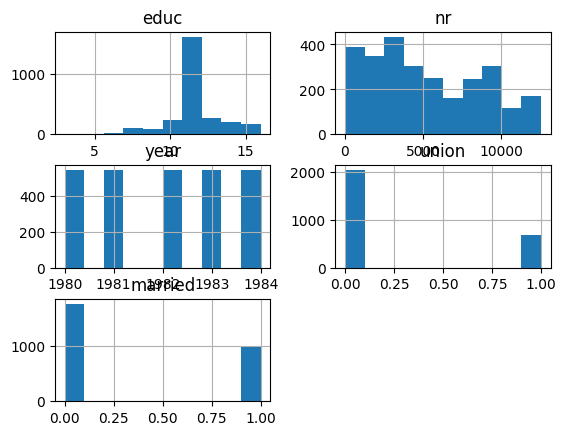

In [236]:
df[['educ','nr','year','union','married']].hist();

# Converting data to numpy format 

> ### Forstå modellen 
> 
> Vi har en dynamisk paneldata-model, hvor afhængige variabel $Union_{it}$ er binær (0 eller 1) 
> 
> * $G(*)$ er en link-funktion 
> * $\rho \cdot union_{it-1}$ betyder, at modellen er dynamisk (tidligere fagforeningsmedlemskab påvirker nutidigt medlemskab)
> * $c_i$ er en individuel effekt, der kan være FE eller RE
> * $z_{it}$ er forklarende variabler (f.eks. $educ_{it}$ og $married_{it}$)
>
>### Hvordan relaterer det sig til en generel GLM (Generel Lineær Model)?
>En GLM er en generalisering af den klassiske lineære regression. Den bruges, når den afhængige variabel ikke nødvendigvis er kontinuert og normalfordelt, men i stedet kan være binær, tælledata, eller en anden type data.
>
> I GLM-modellen har vi tre vigtige elementer:
> * Stokastisk komponent: Beskriver fordelingen af den afhængige variabel Y
> * Systematisk komponent: En lineær kombination af forklarende variabler X
> * Link-funktion: Forbinder den systematiske komponent med den stokastiske komponent.
>
> Den generelle form for en GLM er: $$ g(E[Y_i|X_i]) = X_i\beta $$
> ## Hvordan passer din model ind i GLM?
>
>Din model estimerer sandsynligheden for, at en person er medlem af en fagforening (\(\text{union}_{it}\)), givet tidligere medlemskab og andre >forklarende variabler.  
>Den generelle form for din model er:
>
>$$
P(\text{union}_{it} = 1 | \text{union}_{i,t-1}, ..., \text{union}_{i0}, z_{it}, c_i) = G(z_{it} \gamma + \rho \cdot \text{union}_{i,t-1} + c_i)
>$$
>
>### Hvis vi sammenligner med en GLM:
> - Stokastisk komponent: $Y_{it} \sim \text{Bernoulli}(p_{it})$ fordi $ Y_{it} $ er binær.
>
>- Systematisk komponent: $\eta_{it} = z_{it} \gamma + \rho \cdot \text{union}_{i,t-1} + c_i$
>
> - Link-funktion:  
>  - Hvis \( G(x) \) er en logit-funktion:  
>    $$
    \log \left( \frac{P(Y=1)}{P(Y=0)} \right) = z_{it} \gamma + \rho \cdot \text{union}_{it-1} + c_i
>   $$
> 
>   hvilket viser, at den inverse logit-funktion bruges til at beregne sandsynligheder.
> * fordel: Gar en pæn odds-fortolkning og hurtigere beregninger
> * ulempe Mindre præcis i halerne af fordelingen  
>
>  * Hvis $G(x)$ er en normalfordelingsfunktion (probit):  
>    $$
    \Phi^{-1} (P(Y=1)) = z_{it} \gamma + \rho \cdot \text{union}_{it-1} + c_i
>    $$
>    Dette er en probit-GLM.
> * Fordel: Passer bedre til data, der følger en normalfordeling
> * Beregningsmæssigt tungere
>
> ### Hvordan passer FE og RE i GLM? 
> Fixed Effects (FE) Logit: Estimeres med betinget likelihood, hvor vi fjerner $c_i$ ved at betinget på summen af $Y_{it}$
>
> Random Effects (RE) Logit: Modellerer $c_i$ som en normalfordelt latent effekt, hvilket passer til GLM med hierarkisk struktur.
>
>
>
> ### Ud fra GLM kan vi direkte se, at vi skal bruge en logit-model:
>
>Vores afhængige variabel er binær → GLM kræver en link-funktion.
> Logit-link sikrer, at sandsynligheder forbliver mellem 0 og 1 
> Logistisk fordeling passer ofte bedre end normalfordeling.
> Teoretiske argumenter for logit over probit:
>
> Logit har en naturlig fortolkning i form af odds-ratioer.
> Logit er numerisk mere stabil og hurtigere end probit.
> Logistisk fordeling håndterer ekstreme værdier bedre end normalfordelingen.
> Valget mellem FE og RE:
>
> FE logit bruges, hvis vi tror, at $c_i$ er korreleret med $X_{it}$
> 
> RE logit bruges, hvis $c_i$ ikke er korreleret med $X_{it}$
> 



In [237]:
df.union.values.shape

(2725,)

> ## Opstil varaiblerne ud fra modellen


In [238]:
# Opret lagged værdi af 'union' for hver individ
df['union_lag'] = df.groupby('nr')['union'].shift(1)

# Fjern første års observationer (som har NaN i `union_lag`)
df = df.dropna(subset=['union_lag']).copy()

# Tilføj en konstant 1-variabel (hvis nødvendigt)
df.loc[:, 'c_i'] = 1  

# Tjek om problemet er løst
print(df)

         nr  year  union  married  educ  union_lag  c_i
1        13  1981      1        0    14        0.0    1
2        13  1982      0        0    14        1.0    1
3        13  1983      0        0    14        0.0    1
4        13  1984      0        0    14        0.0    1
9        17  1981      0        0    13        0.0    1
...     ...   ...    ...      ...   ...        ...  ...
4348  12534  1984      0        1    11        0.0    1
4353  12548  1981      0        0     9        0.0    1
4354  12548  1982      0        0     9        0.0    1
4355  12548  1983      0        1     9        0.0    1
4356  12548  1984      1        1     9        0.0    1

[2180 rows x 7 columns]


In [239]:
Nobs, k, n, T, y, x = indexmodels.panel_setup(df, yvar='union', xvar=['union_lag', 'married', 'educ'], groupvar='nr')

Pooled Logit 

In [240]:
result_pooled = indexmodels.pooled(df, yvar='union', xvar=['union_lag', 'married', 'educ'], groupvar='nr', model='logit')

Pooled logit
Dep. var. : union 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
union_lag       3.11384     0.16199    19.22298    -0.00000     0.37261
married         0.08168     0.12747     0.64075     0.00001     0.00977
educ           -0.19003     0.00907   -20.96192     0.00003    -0.02274

# of groups:      : 545
# of observations : 2180
# log-likelihood. : -859.6192116556285 

Iteration info: 6 iterations, 7 evaluations of objective, and 7 evaluations of gradients
Elapsed time: 0.1132 seconds



In [241]:
beta_init = result_pooled.theta_hat  # Ekstraherer de estimerede parametre

log_likelihood = indexmodels.Q_pooled(y, x, T, beta_init, model='logit', out='Q')
print("Negativ log-likelihood (Q_pooled):", log_likelihood)


Negativ log-likelihood (Q_pooled): 1.577282957166291


pooled Probit

In [242]:
result_pooled = indexmodels.pooled(df, yvar='union', xvar=['union_lag', 'married', 'educ'], groupvar='nr', model='probit')

Pooled probit
Dep. var. : union 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
union_lag       1.83571     0.09101    20.17144     0.00000     0.39981
married         0.03792     0.07017     0.54036     0.00000     0.00826
educ           -0.11025     0.00467   -23.59303     0.00002    -0.02401

# of groups:      : 545
# of observations : 2180
# log-likelihood. : -859.8837903761435 

Iteration info: 8 iterations, 9 evaluations of objective, and 9 evaluations of gradients
Elapsed time: 0.1403 seconds



Random Effects Logit 

In [243]:
Logit_RE = indexmodels.rand_effect(df, yvar='union', xvar=['union_lag', 'married', 'educ'], groupvar='nr', model='logit')

# Hent estimerede parametre og kovariansmatrix
theta_RE = Logit_RE["theta_hat"]  # Estimerede koefficienter
Cov_m_RE = Logit_RE["cov"]  # Kovariansmatrix

# Wald test for H0: ρ = 0 (tester kun 'union_lag')
C_RE = np.array([[1 if var == 'union_lag' else 0 for var in ['union_lag', 'married', 'educ','sigma_a']]])

# Beregn Wald-teststatistik
W_RE = (C_RE @ theta_RE).T
Sigma_RE = C_RE @ Cov_m_RE @ C_RE.T

# Brug pseudo-invers for at undgå matrix-inversionsfejl
Sigma_inv_RE = np.linalg.pinv(Sigma_RE)

Wald_RE = W_RE @ Sigma_inv_RE @ W_RE

# Beregn p-værdi
P_val_RE = 1 - scipy.stats.chi2.cdf(Wald_RE.squeeze(), df=1)

# Print resultater
print(f"Wald test statistic: {Wald_RE.squeeze():.3f}")
print(f"p-value: {P_val_RE:.3f}")

# Konklusion
if P_val_RE < 0.05:
    print("==> Vi afviser H0: Der er signifikant state dependence (ρ ≠ 0).")
else:
    print("==> Vi kan IKKE afvise H0: Ingen signifikant state dependence (ρ = 0).")



Random effects logit
Dep. var. : union 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
union_lag       2.56729     0.24672    10.40548     0.00000     0.27438
married         0.08156     0.17086     0.47736     0.00000     0.00872
educ           -0.20607     0.01212   -16.99811     0.00000    -0.02202
sigma_a         1.34293     0.27702     4.84772     0.00000     0.14352

# of groups:      : 545
# of observations : 2180
# log-likelihood. : -852.0218562277482 

Iteration info: 22 iterations, 25 evaluations of objective, and 25 evaluations of gradients
Elapsed time: 0.6508 seconds

Wald test statistic: 108.274
p-value: 0.000
==> Vi afviser H0: Der er signifikant state dependence (ρ ≠ 0).


In [244]:
beta_init1 = result_re.theta_hat  # Ekstraherer de estimerede parametre

log_likelihood = indexmodels.Q_RE(y, x, T, beta_init1, model='logit', out='Q')
print("Negativ log-likelihood (Q_pooled):", log_likelihood)


Negativ log-likelihood (Q_pooled): 1.5633428554637583


Re probit

In [245]:
print(Probit_RE.keys())  # Efter du har kørt rand_effect()


dict_keys(['fun', 'jac', 'hess_inv', 'nfev', 'njev', 'status', 'success', 'message', 'x', 'nit', 'parnames', 'theta_hat', 'se', 't-values', 'cov', 'Q', 'time', 's_i', 'sigma_a', 'yvar', 'xvar', 'Nobs', 'k', 'n', 'T', 'APE'])


In [246]:
# Estimer Random Effects Probit
Probit_RE = indexmodels.rand_effect(df, yvar='union', xvar=['union_lag', 'married', 'educ'], groupvar='nr', model='probit')

# Hent estimerede parametre og kovariansmatrix
theta_RE = Probit_RE["theta_hat"]  # Estimerede koefficienter
Cov_m_RE = Probit_RE["cov"]  # Kovariansmatrix

# Wald test for H0: ρ = 0 (tester kun 'union_lag')
C_RE = np.array([[1 if var == 'union_lag' else 0 for var in ['union_lag', 'married', 'educ','sigma_a']]])

# Beregn Wald-teststatistik
W_RE = (C_RE @ theta_RE).T
Sigma_RE = C_RE @ Cov_m_RE @ C_RE.T

# Brug pseudo-invers for at undgå matrix-inversionsfejl
Sigma_inv_RE = np.linalg.pinv(Sigma_RE)

Wald_RE = W_RE @ Sigma_inv_RE @ W_RE

# Beregn p-værdi
P_val_RE = 1 - scipy.stats.chi2.cdf(Wald_RE.squeeze(), df=1)

# Print resultater
print(f"Wald test statistic: {Wald_RE.squeeze():.3f}")
print(f"p-value: {P_val_RE:.3f}")

# Konklusion
if P_val_RE < 0.05:
    print("==> Vi afviser H0: Der er signifikant state dependence (ρ ≠ 0).")
else:
    print("==> Vi kan IKKE afvise H0: Ingen signifikant state dependence (ρ = 0).")


Random effects probit
Dep. var. : union 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
union_lag       1.47763     0.15021     9.83716     0.00000     0.31087
married         0.03735     0.09489     0.39363    -0.00000     0.00786
educ           -0.11748     0.00645   -18.20399     0.00000    -0.02472
sigma_a         0.75980     0.16411     4.62982     0.00000     0.15985

# of groups:      : 545
# of observations : 2180
# log-likelihood. : -852.4439678822002 

Iteration info: 19 iterations, 21 evaluations of objective, and 21 evaluations of gradients
Elapsed time: 0.7226 seconds

Wald test statistic: 96.770
p-value: 0.000
==> Vi afviser H0: Der er signifikant state dependence (ρ ≠ 0).


### Fixed Effects Logit

**The trick:**
- Model the joint distribution of $y_{i}$ conditional on $x_{i}$, $c_{i}$ *and* $n_{i}=\sum_{t}y_{it}$
- In the logit model, it turns out that this does not depend on $c_{i}.$
- For $T=2$ we have
\begin{align*}
P\left( y_{i2}=1|x_{i},c_{i},n_{i}=1\right) &=\Lambda \left( \left(x_{i2}-x_{i1}\right) \beta \right) \\
P\left( y_{i1}=1|x_{i},c_{i},n_{i}=1\right) &=1-\Lambda \left( \left(
x_{i2}-x_{i1}\right) \beta \right) 
\end{align*}

$$
l_{i}\left( \beta \right) =\left(n_{i}=1\right) \left \{ 
\begin{array}{c} 
w_{i}\Lambda \left( \left( x_{i2}-x_{i1}\right) \beta \right) + \\ 
\left( 1-w_{i}\right) \left( 1-\Lambda \left( \left( x_{i2}-x_{i1}\right) \beta \right) \right)
\end{array}
\right \} 
$$
- NOTE: We cannot use this trick eliminate $c_{i}$ in the probit model

### Fixed Effects Logit: Identification
Identification:
- Conditional distribution of $y_{it}$ is not informative about $\beta $, when $n_{i}=0$ or $n_{i}=T$ 
(since $n_{i}=0$ and $n_{i}=2$ perfectly predict $y_{it}$)
- We therefore need time-series variation in $y_{it}$ to identify $\beta $

**Identified objects**
- We can identify $\beta$ (up to scale) and obtain the effect on the log-odd ratio:
$$
\ln \left[ \frac{\left( \Lambda \left( x_{t}^{\prime }\beta \right) \right) 
}{\left( 1-\Lambda \left( x_{t}^{\prime }\beta \right) \right) }\right] = x_{t}^{\prime }\beta +c%
$$

**Unidentified objects**
- Partial effects cannot be estimated unless we assume *value* of $c$
- $APE$ can't be estimated - since we do not assume *distribution* of $c$

In [247]:
# Antag at df allerede er et pandas DataFrame
# y_it: Binær afhængig variabel (forbliver uændret)
y_it = ['union']

# x_it: Tidsvarierende forklarende variabler (transformeres)
x_it = ['union_lag', 'married']

# x_t: Tidsdummyer (bevares)
x_t = [col for col in df.columns if 'year_' in col]

# x_i: Tidkonstante forklarende variabler (bruges IKKE i FE)
x_i = ['educ']

# groupvar: Enheds-ID (f.eks. individnummer)
groupvar = 'nr'

# Antal tidsperioder per individ
T = df['year'].nunique()

# Opret kopi af datasættet for transformation
df_transformed = df.copy()

# Apply within-transformation (demeaning) for de tidsvarierende variabler
for var in x_it:
    df_transformed[var] = df[var] - df.groupby(groupvar)[var].transform('mean')

# Sørg for, at y_it (afhængig variabel) forbliver uændret
df_transformed[y_it] = df[y_it]  # Bevarer original værdier for union

# Tilføj tidsdummyer (hvis de er nødvendige i regressionen)
df_transformed[x_t] = df[x_t]  # Bevarer tidsdummyer

# Kontroller det transformerede datasæt
print(df_transformed.head())


   nr  year  union  married  educ  union_lag  c_i
1  13  1981      1      0.0    14      -0.25    1
2  13  1982      0      0.0    14       0.75    1
3  13  1983      0      0.0    14      -0.25    1
4  13  1984      0      0.0    14      -0.25    1
9  17  1981      0      0.0    13       0.00    1


In [248]:
print(Logit_FE.keys())

dict_keys(['x', 'success', 'status', 'fun', 'jac', 'nfev', 'njev', 'nhev', 'nit', 'message', 'hess', 'hess_inv', 'parnames', 'theta_hat', 'se', 't-values', 'cov', 'Q', 'time', 's_i', 'yvar', 'xvar', 'Nobs', 'k', 'n', 'T', 'APE'])


In [249]:


# Estimer Fixed Effects Logit
Logit_FE = indexmodels.pooled(df_transformed, yvar='union', xvar=x_it + x_t + x_i, groupvar='nr', model='logit')

# Wald test for H0: ρ = 0 
C_FE = np.array([[1 if var == 'union_lag' else 0 for var in x_it + x_t + x_i]])  # Sikrer at vi kun tester union_lag

# Beregn Wald-teststatistik
W = (C_FE @ Logit_FE["theta_hat"]).T
Sigma = C_FE @ Logit_FE["cov"] @ C_FE.T

# Brug pseudo-invers for at undgå matrix-inversionsfejl
Sigma_inv = np.linalg.pinv(Sigma)  # Brug pseudo-invers i stedet for np.linalg.inv()

Wald_FE = W @ Sigma_inv @ W

# Beregn p-værdi
P_val_FE = 1 - scipy.stats.chi2.cdf(Wald_FE.squeeze(), df=1)

# Print resultater
print(f"Wald test statistic: {Wald_FE.squeeze():.3f}")
print(f"p-value: {P_val_FE:.3f}")

# Konklusion
if P_val_FE < 0.05:
    print("==> Vi afviser H0: Der er signifikant state dependence (ρ ≠ 0).")
else:
    print("==> Vi kan IKKE afvise H0: Ingen signifikant state dependence (ρ = 0).")


Pooled logit
Dep. var. : union 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
union_lag      -0.38120     0.17833    -2.13757     0.00000    -0.07194
married        -0.07490     0.13777    -0.54368     0.00000    -0.01414
educ           -0.09176     0.00708   -12.95250     0.00002    -0.01732

# of groups:      : 545
# of observations : 2180
# log-likelihood. : -1230.6268324143316 

Iteration info: 5 iterations, 6 evaluations of objective, and 6 evaluations of gradients
Elapsed time: 0.0808 seconds

Wald test statistic: 4.569
p-value: 0.033
==> Vi afviser H0: Der er signifikant state dependence (ρ ≠ 0).


In [250]:


# Fixed Effects Probit
Probit_FE = indexmodels.pooled(df_transformed, yvar='union', xvar=x_it + x_t + x_i, groupvar='nr', model='probit')

# Wald test for H0: ρ = 0 
C_FE = np.array([[1 if var == 'union_lag' else 0 for var in x_it + x_t + x_i]])  # Sikrer at vi kun tester union_lag

# Beregn Wald-teststatistik
W = (C_FE @ Probit_FE["theta_hat"]).T
Sigma = C_FE @ Probit_FE["cov"] @ C_FE.T

# Brug pseudo-invers for at undgå matrix-inversionsfejl
Sigma_inv = np.linalg.pinv(Sigma)  # Brug pseudo-invers i stedet for np.linalg.inv()

Wald_FE = W @ Sigma_inv @ W

# Beregn p-værdi
P_val_FE = 1 - scipy.stats.chi2.cdf(Wald_FE.squeeze(), df=1)

# Print resultater
print(f"Wald test statistic: {Wald_FE.squeeze():.3f}")
print(f"p-value: {P_val_FE:.3f}")

# Konklusion
if P_val_FE < 0.05:
    print("==> Vi afviser H0: Der er signifikant state dependence (ρ ≠ 0).")
else:
    print("==> Vi kan IKKE afvise H0: Ingen signifikant state dependence (ρ = 0).")


Pooled probit
Dep. var. : union 

parnames      theta_hat          se    t-values         jac         APE
----------  -----------  ----------  ----------  ----------  ----------
union_lag      -0.20913     0.10470    -1.99746    -0.00002    -0.06677
married        -0.04609     0.08135    -0.56657     0.00001    -0.01472
educ           -0.05625     0.00416   -13.50759    -0.00004    -0.01796

# of groups:      : 545
# of observations : 2180
# log-likelihood. : -1230.7434961774748 

Iteration info: 6 iterations, 7 evaluations of objective, and 7 evaluations of gradients
Elapsed time: 0.1077 seconds

Wald test statistic: 3.990
p-value: 0.046
==> Vi afviser H0: Der er signifikant state dependence (ρ ≠ 0).


## Hausmann

In [265]:
from tabulate import tabulate

# Hent estimerede parametre fra FE og RE
B_fe = Probit_FE["theta_hat"]  # Fixed Effects koefficienter
B_re = Probit_RE["theta_hat"]  # Random Effects koefficienter

# Hent kovariansmatricer
Cov_fe = Probit_FE["cov"]
Cov_re = Probit_RE["cov"]


# Fjern den ekstra parameter (sigma_a) fra RE, hvis den findes
if B_re.shape[0] > B_fe.shape[0]:  
    B_re = B_re[:-1]  # Fjern sidste element (sigma_a)


# Beregn forskellen mellem FE og RE koefficienter
Hat_diff =  B_fe - B_re 

# Fjern den ekstra parameter fra RE's kovariansmatrix, hvis den findes
if Cov_re.shape[0] > Cov_fe.shape[0]:
    Cov_re = Cov_re[:-1, :-1]  # Fjern sigma_a fra RE's kovariansmatrix


# Beregn forskellen mellem kovariansmatricerne
cov_diff = Cov_fe - Cov_re

# Brug pseudo-invers for at undgå matrix-inversionsfejl
cov_diff_inv = np.linalg.inv(cov_diff)

# Beregn Hausman-teststatistikken
H = Hat_diff.T @ cov_diff_inv @ Hat_diff

# Beregn frihedsgrader (antal testede parametre)
df_h = len(Hat_diff)

# Beregn p-værdi fra chi2-fordeling
p_val = chi2.sf(H.item(), df_h)

# Udskriv resultater
def print_h_test(fe_result, re_result, hat_diff, p_val):
    table = []
    for i in range(len(hat_diff)):
        row = [
            fe_result["theta_hat"][i],  
            re_result["theta_hat"][i],  
            hat_diff[i]
        ]
        table.append(row)

    print(tabulate(table, headers=["b_fe", "b_re", "b_diff"], floatfmt=".4f"))
    print(f"\nHausman test statistic: {H.item():.2f}, p-value: {p_val:.4f}")

# Kør og vis testen
print_h_test(Probit_FE, Probit_RE, Hat_diff, p_val)

# Konklusion
if p_val < 0.05:
    print("==> Vi afviser H0: FE er bedre end RE.")
else:
    print("==> Vi kan IKKE afvise H0: RE er mere effektiv.")


   b_fe     b_re    b_diff
-------  -------  --------
-0.2091   1.4776   -1.6868
-0.0461   0.0374   -0.0834
-0.0562  -0.1175    0.0612

Hausman test statistic: -99.80, p-value: 1.0000
==> Vi kan IKKE afvise H0: RE er mere effektiv.


In [268]:
from tabulate import tabulate

# Hent estimerede parametre fra FE og RE
B_fe = Logit_FE["theta_hat"]  # Fixed Effects koefficienter
B_re = Logit_RE["theta_hat"]  # Random Effects koefficienter

# Hent kovariansmatricer
Cov_fe = Logit_FE["cov"]
Cov_re = Logit_RE["cov"]


# Fjern den ekstra parameter (sigma_a) fra RE, hvis den findes
if B_re.shape[0] > B_fe.shape[0]:  
    B_re = B_re[:-1]  # Fjern sidste element (sigma_a)


# Beregn forskellen mellem FE og RE koefficienter
Hat_diff =  B_fe - B_re 

# Fjern den ekstra parameter fra RE's kovariansmatrix, hvis den findes
if Cov_re.shape[0] > Cov_fe.shape[0]:
    Cov_re = Cov_re[:-1, :-1]  # Fjern sigma_a fra RE's kovariansmatrix


# Beregn forskellen mellem kovariansmatricerne
cov_diff = Cov_fe - Cov_re

# Brug pseudo-invers for at undgå matrix-inversionsfejl
cov_diff_inv = np.linalg.inv(cov_diff)

# Beregn Hausman-teststatistikken
H = Hat_diff.T @ cov_diff_inv @ Hat_diff

# Beregn frihedsgrader (antal testede parametre)
df_h = len(Hat_diff)

# Beregn p-værdi fra chi2-fordeling
p_val = chi2.sf(H.item(), df_h)

# Udskriv resultater
def print_h_test(fe_result, re_result, hat_diff, p_val):
    table = []
    for i in range(len(hat_diff)):
        row = [
            fe_result["theta_hat"][i],  
            re_result["theta_hat"][i],  
            hat_diff[i]
        ]
        table.append(row)

    print(tabulate(table, headers=["b_fe", "b_re", "b_diff"], floatfmt=".4f"))
    print(f"\nHausman test statistic: {H.item():.2f}, p-value: {p_val:.4f}")

# Kør og vis testen
print_h_test(Logit_FE, Logit_RE, Hat_diff, p_val)

# Konklusion
if p_val < 0.05:
    print("==> Vi afviser H0: FE er bedre end RE.")
else:
    print("==> Vi kan IKKE afvise H0: RE er mere effektiv.")


   b_fe     b_re    b_diff
-------  -------  --------
-0.3812   2.5673   -2.9485
-0.0749   0.0816   -0.1565
-0.0918  -0.2061    0.1143

Hausman test statistic: 37607.10, p-value: 0.0000
==> Vi afviser H0: FE er bedre end RE.


In [266]:
from tabulate import tabulate

# Hent estimerede parametre fra FE og RE
B_fe = Logit_FE["theta_hat"]  # Fixed Effects koefficienter
B_re = Logit_RE["theta_hat"]  # Random Effects koefficienter

# Hent kovariansmatricer
Cov_fe = Logit_FE["cov"]
Cov_re = Logit_RE["cov"]

# Fjern konstantleddet fra både FE og RE for at sikre korrekt sammenligning
B_fe = B_fe[1:]  # Fjerner konstantled fra FE
B_re = B_re[1:-1]  # Fjerner konstantled og sigma_a fra RE
Hat_diff = B_fe - B_re  # Forskel mellem FE og RE koefficienter

# Fjern konstantled fra RE's kovariansmatrix for at matche FE
Cov_fe = Cov_fe[1:, 1:]
Cov_re = Cov_re[1:-1, 1:-1]  # Fjern sigma_a fra RE's kovariansmatrix

# Beregn forskellen mellem kovariansmatricerne
cov_diff = Cov_fe - Cov_re

# Brug pseudo-invers for at undgå matrix-inversionsfejl
cov_diff_inv = np.linalg.inv(cov_diff)

# Beregn Hausman-teststatistikken
H = Hat_diff.T @ cov_diff_inv @ Hat_diff

# Beregn frihedsgrader (antal testede parametre)
df_h = len(Hat_diff)

# Beregn p-værdi fra chi2-fordeling
p_val = chi2.sf(H.item(), df_h)

# Udskriv resultater
def print_h_test(fe_result, re_result, hat_diff, p_val):
    table = []
    for i in range(len(hat_diff)):
        row = [
            fe_result["theta_hat"][i+1],  # +1 for at springe konstantleddet over
            re_result["theta_hat"][i+1],  # +1 for at springe konstantleddet over
            hat_diff[i]
        ]
        table.append(row)

    print(tabulate(table, headers=["b_fe", "b_re", "b_diff"], floatfmt=".4f"))
    print(f"\nHausman test statistic: {H.item():.2f}, p-value: {p_val:.4f}")

# Kør og vis testen
print_h_test(Logit_FE, Logit_RE, Hat_diff, p_val)

# Konklusion
if p_val < 0.05:
    print("==> Vi afviser H0: FE er bedre end RE.")
else:
    print("==> Vi kan IKKE afvise H0: RE er mere effektiv.")


   b_fe     b_re    b_diff
-------  -------  --------
-0.0749   0.0816   -0.1565
-0.0918  -0.2061    0.1143

Hausman test statistic: -12267.69, p-value: 1.0000
==> Vi kan IKKE afvise H0: RE er mere effektiv.
